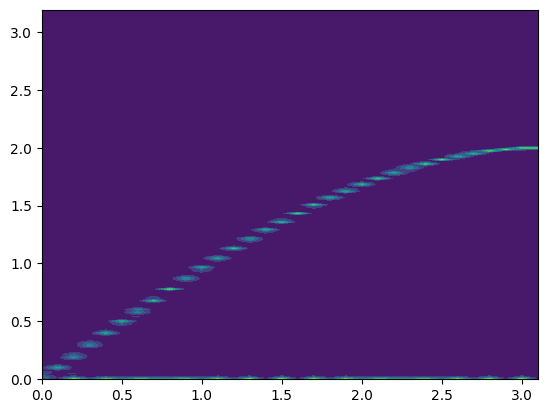


---


# 1D PHONONIC CRYSTAL NUMERICAL SOLVER#
A comprehensive toolkit to explore phononic behaviors in metamaterials. Analyze time and spatial profiles, perform FFT, generate animations, and derive numerical dispersion curves




In [112]:
import numpy as np
from scipy.integrate import solve_ivp
import time
import math
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output, display
from numpy import exp,abs,abs,cos,sin,tan,exp,sinh,cosh,tanh,floor,ceil,exp,log10,log2,log
import json
from google.colab import files
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, ifft
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'colab'
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
from numpy import savetxt
import pandas as pd

In the next section, modify the spring relation and damping model according to your preferences. Please note that 'Fomega' represents the linear frequency and **should not be altered**

In [113]:
# Important functions for the program
# just change Spring and damping functions

def fomega(Wavenumber):
    """
    Calculates the linear frequency based on the given wavenumber.

    Args:
    - Wavenumber: Wavenumber

    Returns:
    - Linear frequency
    """
    return np.sqrt(2 - 2 * np.cos(Wavenumber))

def springModel(x1, x2, t, element):
    """
    Calculates the displacement relation (F_u) based on the given inputs.

    Args:
    - x1: Displacement at point 1
    - x2: Displacement at point 2
    - t: Time parameter
    - element: Element parameter (if used)

    Returns:
    - Displacement relation (F_u)
    """
    x = x1 - x2  # Calculate displacement
    return x  # Return the displacement relation
    # Uncomment and modify below lines for alternative calculations
    # return x + 0.001 * np.abs(x)
    # return np.exp(-1 * x) * (1 - np.exp(-1 * x))

def dampingModel(x1, x2, x1_dot, x2_dot, t, element):
    """
    Calculates the damping relation (F_udot_u) based on the given inputs.

    Args:
    - x1: Displacement at point 1
    - x2: Displacement at point 2
    - x1_dot: Velocity at point 1
    - x2_dot: Velocity at point 2
    - t: Time parameter
    - element: Element parameter (if used)

    Returns:
    - Velocity relation (F_udot_u)
    """
    return 0  # No damping effect considered in this implementation; always returns 0
    # You can add damping calculations here if required

def setInitialCondition(node,wave_number,amplitude):
  """
    Sets the initial conditions for the system based on wave number and amplitude.

    Args:
    - wave_number: Wavenumber used to set initial conditions
    - amplitude: Amplitude used to set initial conditions

    Returns:
    - Initial conditions array
    """
  init            = np.zeros((node*2));
  for i in range(0,node,1):
    init[2*i]     = amplitude*np.cos(wave_number*i);
    init[2*i+1]   = amplitude*np.sin(wave_number*i)*fomega(wave_number);
  return init;

This is the core class of the program. Edit only if you know what you're doing

In [124]:
class numericalPCs:

  def __init__(self,node = 100,initial_condition = np.zeros((100*2)),time_step = 50,time_end = 300):
    # number of masses
    self.node      = node;
    # Set the initial condition (including wave number and amplitude)
    self.init      = initial_condition;
    # Set the time span for the simulation; these values facilitate our study for FFT
    self.sr        = time_step;
    self.ts        = 1.0/sr;
    self.time_end  = time_end;
    self.timing    = np.arange(0,time_end,self.ts);

  #Main function solving the dynamics using Runge-Kutta
  def run(self):
    sol = solve_ivp(self.oneDimSys, [0, self.time_end],self.init, args=(self.node,2),t_eval=self.timing);
    self.results          = sol.y;
    self.transposed_data  = np.transpose(sol.y)
    return self;

  # the Great function of numerical Dispersion :)
  def DISPERSION(self,amplitude = 1,wave_numbers = np.arange(0,np.pi,.1)):
    iter      = 0;
    for k in wave_numbers:

      # First, set initial conditions with respect to wave number and amplitude
      init = setInitialCondition(node = node,wave_number = k ,amplitude = amplitude)
      # solve
      sol = solve_ivp(self.oneDimSys, [0, self.time_end],init, args=(self.node,2),t_eval=self.timing);
      transposed_data = np.transpose(sol.y);
      overHistory     = transposed_data[0:,self.node];
      # Perform FFT
      freq1,fin_Y1    = PC.FFrRaw(overHistory,self.sr);
      pos             = np.where(freq1<3.2)
      # Store the data properly
      print("Currently at : ",k)
      if(iter > 0):
          MainData[:,iter] = fin_Y1[pos[0]]
          plt.plot(MainData[:,iter])
          df.insert(iter+1, k, fin_Y1[pos[0]], True)
      else:
          df = pd.DataFrame({'x':freq1[pos[0]]})
          f1 = freq1[pos[0]];
          MainData = np.zeros((f1.shape[0],wave_numbers.shape[0]))
          MainData[:,iter] = fin_Y1[pos[0]]
          plt.plot(MainData[:,iter])
          df.insert(iter+1, k, fin_Y1[pos[0]], True)
      iter = iter+1
    # Plot the dispersion curve
    [X,Y] = np.meshgrid(f1.T,wave_numbers)
    fig   = plt.figure()
    ax    = fig.subplots()
    ax.contourf(Y,X,MainData.T)
    self.dipersionData = MainData
    return self

  # State-space
  def oneDimSys(self,t,z,node,data):
    dy = np.zeros((node*2));
    dy[0] = z[1];
    dy[1] = (-springModel(z[0],0,t,0))+ (-dampingModel(z[0],0,z[1],0,t,0)) -springModel(z[0],z[2],t,1)+  (-dampingModel(z[0],z[2],z[1],z[3],t,1)) ;
    j_iter = -1;
    for i in np.arange(3,(node*2) -1,2):
          dy[i-1] = z[i];
          dy[i] = (-springModel(z[i-1],z[i-3],t,2+j_iter)  -springModel(z[i-1],z[i+1],t,3+j_iter)  +  (-dampingModel(z[i-1],z[i-3],z[i],z[i-2],t,2+j_iter))+ (-dampingModel(z[i-1],z[i+1],z[i],z[i+2],t,2+j_iter))   )
          j_iter=j_iter+1;
          # Sometimes, we need to apply specific or special conditions
          # if(j_iter == (node/2) + 1 ):
          #    dy[i] = dy[i]*1e3
    dy[node*2-2] = z[node*2-1];
    dy[node*2-1] = (-springModel(z[node*2-2],z[node*2-4],t,node-1) + (-dampingModel(z[node*2-2],z[node*2-4],z[node*2-1],z[node*2-3],t,2+j_iter)))
    return dy

  # Animating function
  def plot_anim(self,data,node,time_sample,frames):
    x       = data[:,0:2*node:2];
    fig, ax = plt.subplots()
    def update(frame):
      ax.cla()
      if(frame == 0 ):
        cf = 0
      else:
        cf = int(np.floor(time_sample/frames)*(frame)) - 1
      contours = ax.plot(np.arange(0,node,1),x[cf,:])
    self.ani = animation.FuncAnimation(fig, update, frames=frames, interval=200)
    return self.ani;


  # FFT & Plotting
  def FFT(self,x,sr):
    freq,fin_Y = self.FFrRaw(x,sr)
    fig        = go.Figure(data=go.Scatter(x=freq, y=fin_Y, mode='lines'))
    fig.update_layout(title='Line Plot',xaxis_title='',yaxis_title='FFt',)
    fig.show()
    return fig,freq,fin_Y

  # FFT calculation
  def FFrRaw(self,x,sr):
    X     = fft(x)
    N     = len(X)
    n     = np.arange(N)
    T     = N/sr
    freq  = (n/T)*2*np.pi;
    fin_Y = np.abs(X)

    return freq,fin_Y

  # Animation generation
  def animate(self,frame = 300):
    anim = self.plot_anim(self.transposed_data,self.node,self.timing.shape[0],frame);
    return anim

  # Plot displacements
  def plotDetails(self):
    sr        = self.sr;
    ts        = self.ts;
    time_end  = self.time_end;
    t         = self.timing;
    node      = self.node;

    x     = self.transposed_data[:,0:node*2:2];
    X     = np.arange(0, node, 1)
    Y     = t/1000
    X, Y  = np.meshgrid(X, Y)

    fig   = plt.figure(figsize=(15, 10))
    gs    = fig.add_gridspec(2, 6)

    ax    = fig.add_subplot(gs[0, 0:3], projection='3d')
    surf  = ax.plot_surface(X, Y, x, cmap=cm.summer,linewidth=0);

    ax.view_init(azim=25, elev=30);
    ax.set_xlabel("Non-dimensional time (T1)")
    ax.set_ylabel("Mass number")
    ax.set_zlabel("Relative Displacment")
    ax.zaxis.labelpad=-0.7

    ax2 = fig.add_subplot(gs[0, 3:7])
    ax2.plot(t/100,x);
    ax2.set_xlabel("Non-dimensional time (T1)")
    ax2.set_ylabel("Relative Displacment")

    ax3 = fig.add_subplot(gs[1,:], projection='3d')
    for i in np.arange(1,node,20):
      ax3.plot3D(np.tile(np.array([i]), t.shape[0]), t/100, x[:,i])
    ax3.view_init(azim=45, elev=50);

    return self

  # Plots the spatial profile for a specific timestep.
  def spatialProfile(self,timestep = 1,figsize=(10,4)):
    overSpatial     = self.transposed_data[timestep,0:2*self.node:2];
    plt.figure(figsize=figsize);
    plt.plot(np.arange(0,self.node)+1,overSpatial);
    return self

  # Plots the history profile for a specific node.
  def historyProfile(self,node = 1,figsize=(10,4)):
    overHistory     = self.transposed_data[:,node];
    plt.figure(figsize=figsize);
    plt.plot(self.timing,overHistory);
    return self

  # Performs FFT (Fast Fourier Transform) on spatial data for a specific timestamp.
  def SpatialFFt(self,timestamp = 1):
    overspatial       = self.transposed_data[timestamp,0:node*2:2];
    fig1,freq1,fin_Y1 = self.FFT(overspatial,sr);
    return self

  # Performs FFT (Fast Fourier Transform) on time history data for a specific node.
  def historyFFt(self,node = 1):
    overHistory       = self.transposed_data[:,node];
    fig1,freq1,fin_Y1 = self.FFT(overHistory,sr);
    return self




#Implementation

We'll begin utilizing our 'numericalPCs' class.

In [125]:
node        = 100 # @param {type:"slider", min:50, max:1000, step:1}
time_end    = 200 # @param {type: "number"}
sr          = 10 # @param {type: "slider", min: 10, max: 1000, step:1}
###############################################
# Write code manually for initial conditions
# If you encounter the variable 'k' anywhere, it represents the wave number
wave_number       = 2 # @param {type: "number"}
amplitude         = 5 # @param {type: "number"}
init              = np.zeros((node*2));
for i in range(0,node,1):
  init[2*i]       = amplitude*np.cos(wave_number*i);
  init[2*i+1]     = amplitude*np.sin(wave_number*i)*fomega(wave_number);
# or use the helper
# init = setInitialCondition(node = node,wave_number = wave_number ,amplitude = amplitude)
###############################################

# Initializing the class
PC = numericalPCs(node = node,initial_condition = init,time_step = sr,time_end = time_end)

In the upcoming section, we'll solve the system's dynamics and proceed to analyze both its historical and spatial profiles

In [116]:
# Running the simulation for a specific initial condition
PC.run();

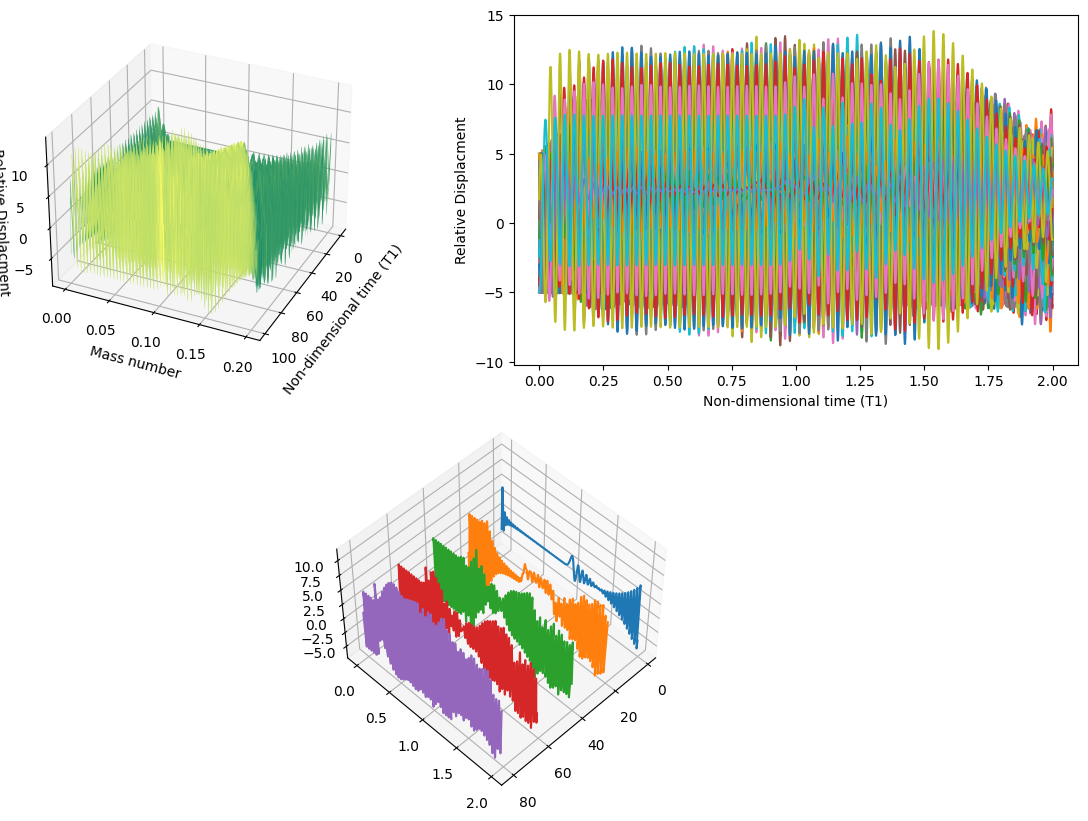

In [117]:
# Obtaining displacement for each mass (node) and nondimensional time
PC.plotDetails();

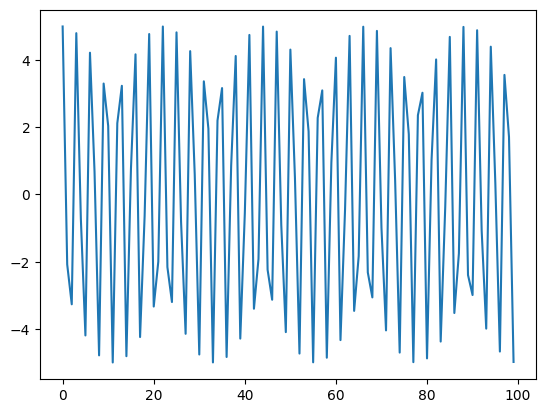

In [118]:
# Animating the profile for better perception
anim = PC.animate(frame=100);
HTML(anim.to_html5_video())

# or save
# Writer = animation.FFMpegWriter(fps=10)
# anim.save('animation.mp4', writer=Writer)

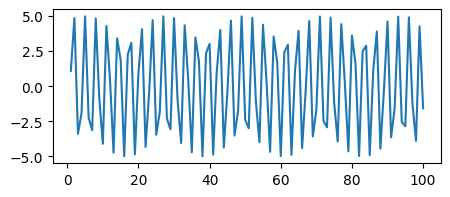

In [119]:
# Ploting spatial profile
PC.spatialProfile(timestep=100,figsize=(5,2))

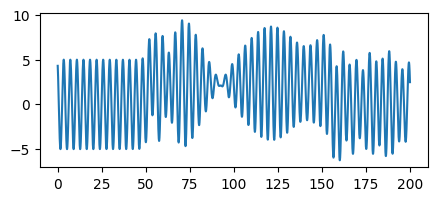

In [120]:
# Ploting spatial profile
PC.historyProfile(node=100,figsize=(5,2));

In [121]:
# FFT over time history and spatial profile
PC.historyFFt(node = 50);
# Note: You need to manually scale the Wave-number FFT with respect to the Brillouin zone
PC.SpatialFFt(timestamp = 50);

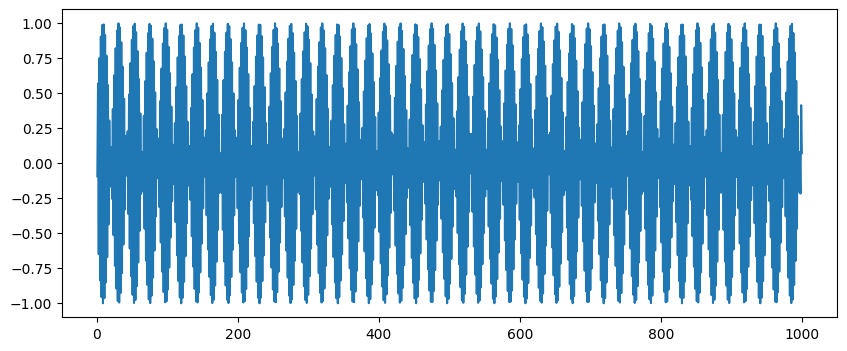

In [122]:
# Easily modify the problem's conditions and rerun the program
node         = 1000;
k            = 3;
amp          = 1;
PC.node      = node;
PC.init      = setInitialCondition(node = node,wave_number = k ,amplitude = amp);

PC.run().spatialProfile(timestep=100).SpatialFFt(timestamp = 100).historyFFt(node = 100);

# Dispersion Curve

Currently at :  0.0
Currently at :  0.1
Currently at :  0.2
Currently at :  0.30000000000000004
Currently at :  0.4
Currently at :  0.5
Currently at :  0.6000000000000001
Currently at :  0.7000000000000001
Currently at :  0.8
Currently at :  0.9
Currently at :  1.0
Currently at :  1.1
Currently at :  1.2000000000000002
Currently at :  1.3
Currently at :  1.4000000000000001
Currently at :  1.5
Currently at :  1.6
Currently at :  1.7000000000000002
Currently at :  1.8
Currently at :  1.9000000000000001
Currently at :  2.0
Currently at :  2.1
Currently at :  2.2
Currently at :  2.3000000000000003
Currently at :  2.4000000000000004
Currently at :  2.5
Currently at :  2.6
Currently at :  2.7
Currently at :  2.8000000000000003
Currently at :  2.9000000000000004
Currently at :  3.0
Currently at :  3.1


<ipython-input-124-6cd8606441f5>:53: UserWarning:

The following kwargs were not used by contour: 'label'



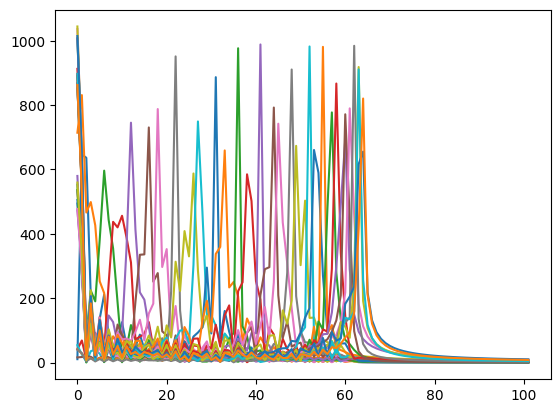

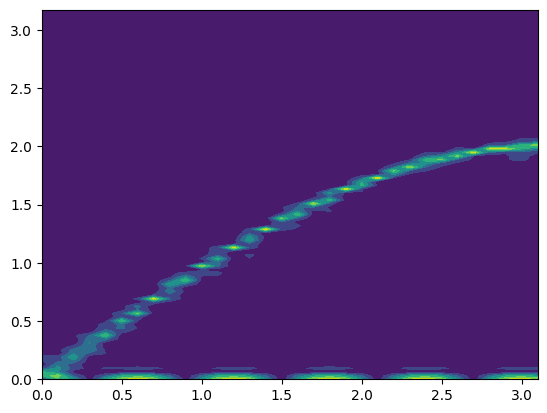

In [126]:
## AND FINNALY, THE DISPERSION CURVE
## YOU DONT NEED to EXECUTE PC.RUN() IF ONLY WANT THE DISPERSION
PC.DISPERSION(amplitude = 1,wave_numbers = np.arange(0,np.pi,.1))